## Notable links
[GitHub](https://github.com/JoeyShapiro/ITS530-cgan/tree/main)
NOTE: That wgan is my attempt at adding embeddings

[Training Embedder](https://sbert.net/docs/training/overview.html)

### NOTES
[wgan](https://www.youtube.com/watch?v=pG0QZ7OddX4)
### TODO
- scale data better
- add embedder
- add everything here

## Embedder

$ y = \frac{x+min}{max-min} $

In [1]:
import torch
import torch.nn as nn

class Compressor(nn.Module):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        input = torch.tanh(input)
        return (input + 1) / 2

In [2]:
items = [ 'sword', 'pickaxe', 'axe', 'hoe', 'shovel' ]
mats = [ 'stone', 'diamond', 'iron', 'gold', 'wood', 'netherite' ]
combs = []

for item in items:
    for mat in mats:
        combs.append(f"{mat} {item}")
        combs.append(f"{item} {mat}")

dataset = []
for comb in combs:
    for comb2 in combs:
        text1 = comb.split(' ')
        text2 = comb2.split(' ')
        # if text1[0] == text2[0] and text1[1] == text2[1]:
        #     similarity = 1
        # elif text1[0] == text2[1] and text1[1] != text2[0]:
        #     similarity = 0.5
        # smart
        similarity = 0
        for word in text1:
            if word in text2:
                similarity += 0.5

        dataset.append({ 'texts': (comb, comb2), 'similarity': similarity })
    
display(dataset[:5])
print(len(dataset))

[{'texts': ('stone sword', 'stone sword'), 'similarity': 1.0},
 {'texts': ('stone sword', 'sword stone'), 'similarity': 1.0},
 {'texts': ('stone sword', 'diamond sword'), 'similarity': 0.5},
 {'texts': ('stone sword', 'sword diamond'), 'similarity': 0.5},
 {'texts': ('stone sword', 'iron sword'), 'similarity': 0.5}]

3600


In [3]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch.nn as nn
from sentence_transformers import models

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(
    in_features=pooling_model.get_sentence_embedding_dimension(),
    out_features=18,
    activation_function=Compressor(),
)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

train_examples = [
    InputExample(texts=d['texts'], label=d['similarity']) for d in dataset
]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10, warmup_steps=100)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

: 

In [62]:
from sentence_transformers import util

sentences = ["stone sword", "I'm full of happiness", "wooden sword", "sword stone", "stone pickaxe"]

#Compute embedding for both lists
embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
embedding_3 = model.encode(sentences[2], convert_to_tensor=True)
embedding_4 = model.encode(sentences[3], convert_to_tensor=True)
embedding_5 = model.encode(sentences[4], convert_to_tensor=True)

print(embedding_1)
print(embedding_1.shape)
print(embedding_2.shape)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))
print(f'{sentences[0]} ?= {sentences[2]} =', util.pytorch_cos_sim(embedding_1, embedding_3))
print(f'{sentences[0]} ?= {sentences[3]} =', util.pytorch_cos_sim(embedding_1, embedding_4))
print(f'{sentences[0]} ?= {sentences[4]} =', util.pytorch_cos_sim(embedding_1, embedding_5))
print(model.encode(sentences[0], convert_to_tensor=True))
print(model.encode(sentences[0], convert_to_tensor=True))

tensor([0.0105, 0.0054, 0.0053, 0.0113, 0.0123, 0.0091, 0.9561, 0.0077, 0.0229,
        0.0056, 0.0123, 0.0289, 0.0038, 0.0084, 0.9038, 0.0124, 0.0243, 0.0116],
       device='mps:0')
torch.Size([18])
torch.Size([18])
stone sword ?= I'm full of happiness = tensor([[0.1430]], device='mps:0')
stone sword ?= wooden sword = tensor([[0.6988]], device='mps:0')
stone sword ?= sword stone = tensor([[0.9999]], device='mps:0')
stone sword ?= stone pickaxe = tensor([[0.5572]], device='mps:0')
tensor([0.0105, 0.0054, 0.0053, 0.0113, 0.0123, 0.0091, 0.9561, 0.0077, 0.0229,
        0.0056, 0.0123, 0.0289, 0.0038, 0.0084, 0.9038, 0.0124, 0.0243, 0.0116],
       device='mps:0')
tensor([0.0105, 0.0054, 0.0053, 0.0113, 0.0123, 0.0091, 0.9561, 0.0077, 0.0229,
        0.0056, 0.0123, 0.0289, 0.0038, 0.0084, 0.9038, 0.0124, 0.0243, 0.0116],
       device='mps:0')


## Dataset

In [30]:
import os
from PIL import Image

In [31]:
keeps = [ 'sword', 'pickaxe', 'axe']#, 'hoe', 'shovel' ]
mats = ['stone', 'diamond']#, 'iron', 'gold', 'wood', 'netherite']
# keeps = ['sword', 'pickaxe']
data = 'minecraft'
SIZE = 32

# reset the data directory
for file in os.listdir(data):
    os.remove(f"{data}/{file}")

for root, dirs, files in os.walk("textures"):
    # pack = root.split(os.sep)[-1]
    pack = root.split('textures/')[-1].replace('/', '-')

    # skip folders that end with '.disabled'
    if ".disabled" in pack:
        continue

    for file in files:
        if file.endswith(".png"):
            # skip normal maps
            if file.endswith("_n.png"):
                print(f"Skipping {root}/{file} because it is a normal map")
                continue

            if file.endswith("_s.png"):
                print(f"Skipping {root}/{file} because it is a specular map")
                continue
            
            if file.endswith("_e.png"):
                print(f"Skipping {root}/{file} because it is an emissive map")
                continue

            # TODO other possible types of maps

            # skip empty images
            if 'empty' in file:
                print(f"Skipping {root}/{file} because it is empty")
                continue

            for keep in keeps:
                if f"_{keep}" in file:
                    # skip if not a stone item
                    if 'stone' not in file and 'diamond' not in file:
                        print(f"Skipping {root}/{file} because it is not a stone item")
                        continue

                    # skip the file if it is not 32x32
                    try:
                        img = Image.open(f"{root}/{file}")
                        if img.size[0] != img.size[1]:
                            print(f"Skipping {root}/{file} because it is not a square ({img.size})")
                            continue
                        if img.size[0] < SIZE:
                            print(f"skipping {root}/{file} because it is not 32x32 ({img.size})")
                            continue

                        os.system(f"cp {root}/{file} {data}/{pack}-{file}")
                    except Exception as e:
                        print(f"Skipping {root}/{file} because it is not an image: {e}")
                    

Skipping textures/helios/netherite_sword.png because it is not a stone item
Skipping textures/helios/wooden_axe.png because it is not a stone item
Skipping textures/helios/wooden_sword.png because it is not a stone item
Skipping textures/helios/golden_pickaxe.png because it is not a stone item
Skipping textures/helios/golden_axe.png because it is not a stone item
Skipping textures/helios/netherite_pickaxe.png because it is not a stone item
Skipping textures/helios/wooden_pickaxe.png because it is not a stone item
Skipping textures/helios/golden_sword.png because it is not a stone item
Skipping textures/helios/iron_pickaxe.png because it is not a stone item
Skipping textures/helios/netherite_axe.png because it is not a stone item
Skipping textures/helios/iron_sword.png because it is not a stone item
Skipping textures/helios/iron_axe.png because it is not a stone item
Skipping textures/helios/tools/silk/gold_pickaxe_04.png because it is not a stone item
Skipping textures/helios/tools/sil

In [32]:
# replace the alpha channel with a solid color using pil
for file in os.listdir(data):
    if file.endswith(".png"):
        img = Image.open(f"{data}/{file}")
        img = img.convert("RGBA")

        if img.size[0] > SIZE:
            print(f"resizing {root}/{file} because it is not {SIZE}x{SIZE} ({img.size})")
            img = img.resize((SIZE, SIZE), Image.NEAREST) # TODO Image.NearestNeighbour
            img.save(f"{root}/{file}")

        datas = img.getdata()
        new_data = []
        for item in datas:
            if item[3] == 0:
                # if the pixel is transparent, replace it with white
                new_data.append((255, 255, 255, 255))
            else:
                new_data.append(item)
        img.putdata(new_data)
        img.save(f"{data}/{file}", "PNG")
        # break

resizing textures/StevensTraditional/models/WolfhoundFantasy-stone_axe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/DragonDance-diamond_pickaxe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/WolfhoundHeavenly-diamond_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-stone_pickaxe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/DragonDance-stone_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-stone_sword_broken.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-diamond_axe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/WolfhoundAsian-diamond_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/XmasBDcraft-diamond_axe.png because it is not 32x32 ((64, 64))
resizing te

In [63]:
# convert the files into a dataset using the dataset lib
import numpy as np

labels = {
    'sword': 0,
    'pickaxe': 1,
    'axe': 2,
    'hoe': 3,
    'shovel': 4
}

def get_label(file):
    if 'sword' in file:
        return 0
    if 'pickaxe' in file:
        return 1
    if 'axe' in file:
        return 2
    if 'hoe' in file:
        return 3
    if 'shovel' in file:
        return 4
    
    # throw an error if the label is not found
    raise Exception(f"Label not found for {file}")

# load the images
dataset = []
for file in os.listdir(data):
    if file.endswith(".png"):
        # img = Image.open(f"{data}/{file}")
        # open the image in black and white
        img = Image.open(f"{data}/{file}")#.convert("L")
        # drop the alpha channel
        img = img.convert("RGB")
        # load image into numpy array and normalize
        img = np.array(img) / 255
        # TODO split on - and _ then flatten
        name = file.replace('_', ' ').replace('.png', '')#.replace('-', ' ')
        # drop the pack name
        name = name.split('-')[1]
        embedding = model.encode(name, convert_to_tensor=True)

        dataset.append((img, get_label(file), embedding.cpu()))

# create the dataset
# images_np = np.array(images)
# images_np = images_np.reshape((images_np.shape[0], 32, 32, 4))
# print(images_np.shape)

# dataset = (images_np, labels)

# store the dataset into a pickle file
import pickle
pickle.dump(dataset, open("mc-dataset.pkl", "wb"))

## GAN

In [64]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [66]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [67]:
from datasets import load_dataset, Split

In [68]:
import torch.autograd as autograd

In [69]:
channels = 3 ## 1 for B&W, 3 for RGB, 4 for RGBA

learning_rate    = 2e-4#0.003  ## Adam default   ## 0.001 2e-4#
batch_size       = 64
N_Epochs         = 1_000#4_000  ##27000  
num_classes = 3
pixels = 32
img_size = pixels*pixels*channels
certainty_repeater = 6# channels**2 - num_classes
print(f"{img_size=}")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps is not None:
    device = torch.device('mps')
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device=}")
# device = 'cpu' # something didnt work for mps

img_size=3072
device=device(type='mps')


In [70]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class MyDataset(VisionDataset):
    classes = [
        'sword',
        'pickaxe',
        'axe',
        'hoe',
        'shovel'
    ]

    def __init__(
        self,
        root: str = "mc-dataset.pkl",
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set

        self.data, self.targets, self.names = self._load_data()

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target, name = self.data[index], int(self.targets[index]), self.names[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy().astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, name

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self):
        with open('mc-dataset.pkl', 'rb') as f:
            data = pickle.load(f)
        
        imgs = []
        labels = []
        names = []
        for i in range(len(data)):
            imgs.append(torch.Tensor(data[i][0]))
            labels.append(data[i][1])
            names.append(data[i][2])

        # if self.train:
        #     data = data[0]
        # else:
        #     data = data[1]
        return imgs, labels, names

img.shape=torch.Size([32, 32, 3]) label=1 name.shape=torch.Size([18])
tensor([0.8222, 0.0075, 0.0165, 0.0097, 0.0104, 0.0126, 0.9274, 0.0084, 0.0123,
        0.0055, 0.0045, 0.0257, 0.0030, 0.0050, 0.0137, 0.0100, 0.0169, 0.0126])


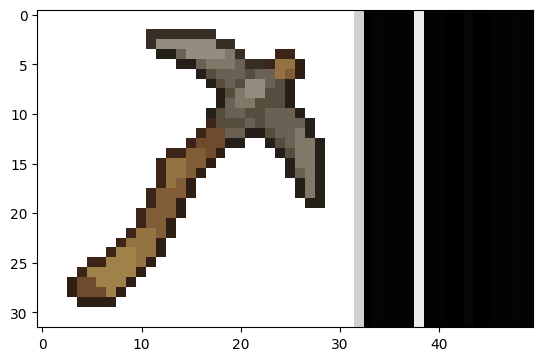

In [71]:
# df = pd.DataFrame(dataset.reshape((dataset.shape[0], 32*32)))
# df.to_csv(f"{data}-dataset.csv", index=False, header=False)

# load the dataset
dataset = MyDataset()

# load the first image in the dataset
# print(dataset[5][0])
img, label, name = dataset[5]
print(f"{img.shape=} {label=} {name.shape=}")
print(name)
img *= 255
name *= 255
name = name.repeat(channels, pixels, 1).permute(1, 2, 0)
img = torch.cat((img, name), dim=1)
plt.imshow(Image.fromarray(img.numpy().astype(np.uint8)))

In [72]:
# display the split of labels in the dataset
for i in range(5):
    print(f"Label {i}: {len([x for x in dataset.targets if x == i])}")

# convert the dataset into a train / test split
# TODO i dont think test is used
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])

# define the dataloader
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Label 0: 159
Label 1: 123
Label 2: 123
Label 3: 0
Label 4: 0


In [73]:

def plot_GAN_losses(list_losses_fake):
    
    the_epochs = [i for i in range(len(list_losses_fake))]  

    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.legend() 
    plt.show()


In [74]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [75]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [76]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 ).to(device)
    return rand_vec

In [77]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) ).to(device)
    return rand_vec

In [78]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, num_classes ) ).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [79]:
list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []

classes = [
    'sword',
    'pickaxe',
    'axe',
    'hoe',
    'shovel'
]

import tqdm

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    pbar = tqdm.tqdm(range(N_Epochs+1))

    for epoch in pbar:
        # shuffle dl_train every epoch
        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for xb, yb, nb in dl_train:              ## xb = [batch, 1, 28, 28]
            xb, yb, nb = xb.to(device), yb.to(device), nb.to(device)

            if xb.shape[0] != batch_size:
                # print(f"skipping batch of size {xb.shape[0]}")
                continue

            if channels == 4 or channels == 3:
                xb = xb.permute(0, 3, 1, 2)
            xb = torch.squeeze(xb, dim=1)
            # TODO how do i deal with this. it was given to 18
            yb = F.one_hot(yb, num_classes=num_classes).repeat(1, certainty_repeater).to(device)
            yb = nb
            # convert nb [batch, 384] to [batch, -1, 32, channels]

            # TODO what is the shape of this. i might be able to just permute the full nb
            yb_certainty = yb.repeat(channels, pixels, 1, 1).permute(2, 0, 1, 3) # [ batch, x (classes), y, channels ]
            # yb_certainty = nb.reshape(batch_size, channels, pixels, -1)
            real = torch.cat( (xb, yb_certainty) , dim=3)

            for _ in range(5):
                noise = torch.cat( (random_G_batch_vector_input(), yb) , dim=1)
                fake = G_model( noise )#.detach()

                real_pred = D_model( real  ).reshape(-1)
                
                inputs = torch.cat( (fake, yb_certainty) , dim=3)
                fake_pred = D_model(  inputs  ).reshape(-1)

                fake_loss   = D_loss_fn(D_model, inputs, real, real_pred, fake_pred)
                # D_opt.zero_grad()
                D_model.zero_grad()
                fake_loss.backward(retain_graph=True)
                D_opt.step()
                
            output = D_model( inputs ).reshape(-1)
            gen_loss = -torch.mean(output)
            G_model.zero_grad()
            gen_loss.backward()
            G_opt.step()
       
            
        if epoch % 10 == 0:
            list_losses_fake.append(        fake_loss.cpu().detach().numpy()  )
            D_fake_loss_rnd = np.round(fake_loss.cpu().detach().numpy(), 3)

            message = f"{D_fake_loss_rnd=}"
            pbar.set_description(message)
            
        # draw an image of each class
        # place them all on the same figure
        if epoch % 100 == 0:
            f, axarr = plt.subplots(nrows=1, ncols=num_classes, figsize=(12,4))
            
            for i in range(num_classes):
                label = torch.tensor([i]).to(device)
                label = F.one_hot(label, num_classes=num_classes)
                label = label.repeat(1, certainty_repeater)

                # create noise and make it 2d
                noise = random_G_vector_input().unsqueeze(0)
                inputs = torch.cat( (noise, label) , dim=1)
                output = G_model( inputs ).cpu()
                # convert output (batch, img_size) to (batch, 4, 32, 32)
                if channels == 4 or channels == 3:
                    # output = output.reshape((-1, 4, pixels, pixels)) # wrong too, lol
                    output = output.reshape((-1, channels, pixels, pixels))
                    # output = output.reshape((-1, 32, 32))

                    img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(32,32)
                elif channels == 1:
                    img = output.detach().numpy()

                if channels == 4 or channels == 3:
                    mode = None
                elif channels == 1:
                    mode = 'L'

                img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)
                # display the image
                axarr[i].imshow(img)
                # place name of class on image
                axarr[i].set_title(classes[i])
            plt.show()
            


In [80]:
def grad_penatly(critic, real, fake):
    # Random weight term for interpolation between real and fake samples
    batch, c, h, w = real.shape
    epsilon = torch.rand((batch, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Take the norm of the gradient
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1) # L2 norm (euclidean norm)
    gradient_penalty = torch.mean((grad_norm - 1) ** 2)
    return gradient_penalty

In [81]:
def wasserstein_loss(D_model, gen_img, real_data, real_pred, fake_pred):
    loss =  - (real_pred.mean() - fake_pred.mean()) + 10 * grad_penatly(D_model, real_data, gen_img)
    return loss

In [82]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 2, 2, 1),
            self._block(features_d * 2, features_d * 4, 2, 2, 1),
            self._block(features_d * 4, features_d * 8, 2, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=2, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.critic(x)

D_fake_loss_rnd=-2.478:   0%|          | 0/1001 [00:00<?, ?it/s]/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_23627/310735984.py:100: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)


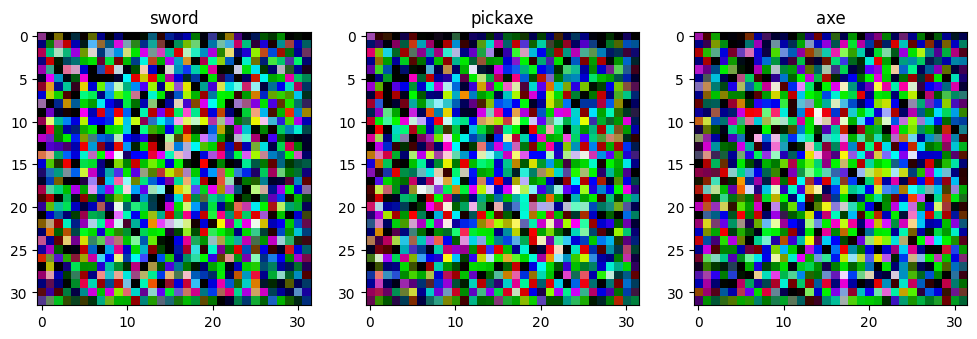

D_fake_loss_rnd=-119.573:  10%|▉         | 100/1001 [01:09<10:42,  1.40it/s]

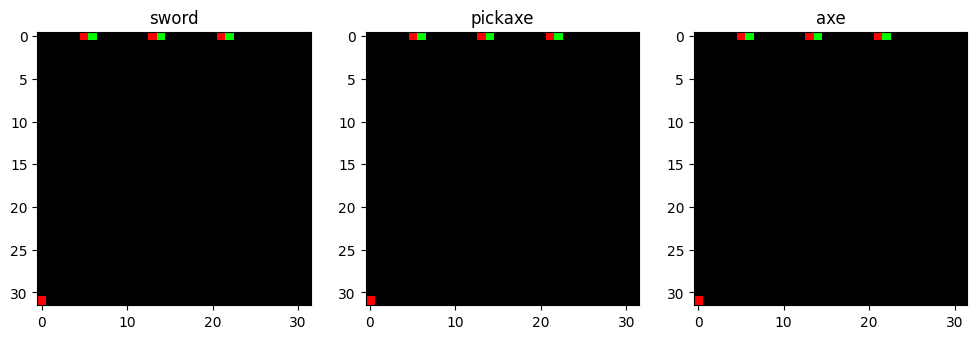

D_fake_loss_rnd=-119.146:  20%|█▉        | 200/1001 [02:21<09:39,  1.38it/s]

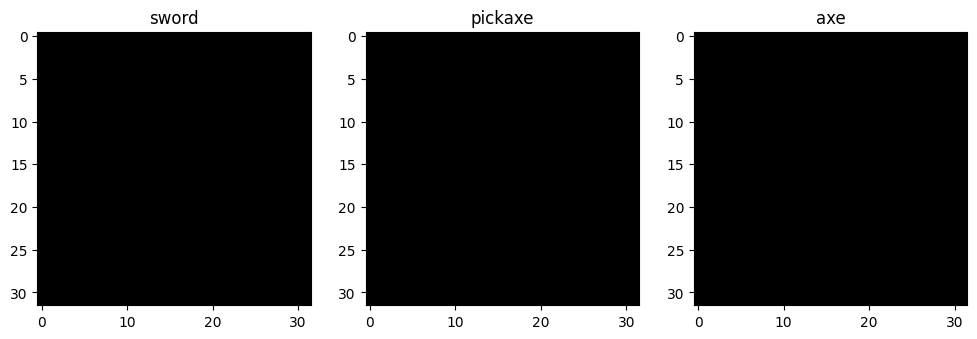

D_fake_loss_rnd=-126.43:  30%|██▉       | 300/1001 [03:35<08:54,  1.31it/s] 

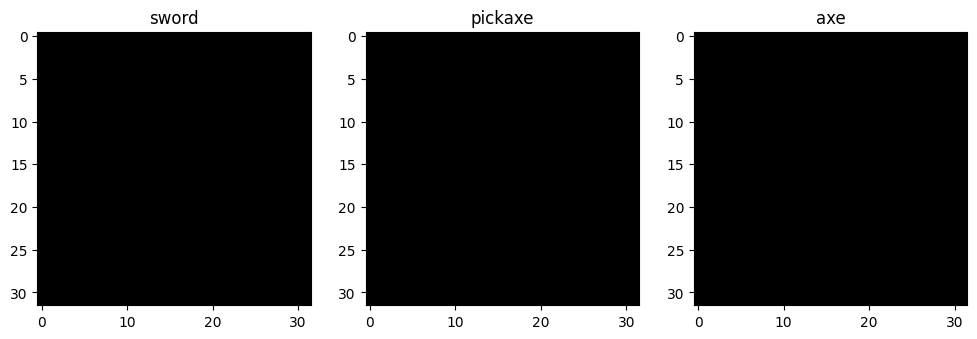

D_fake_loss_rnd=71.863:  40%|███▉      | 400/1001 [05:05<10:22,  1.04s/it]  

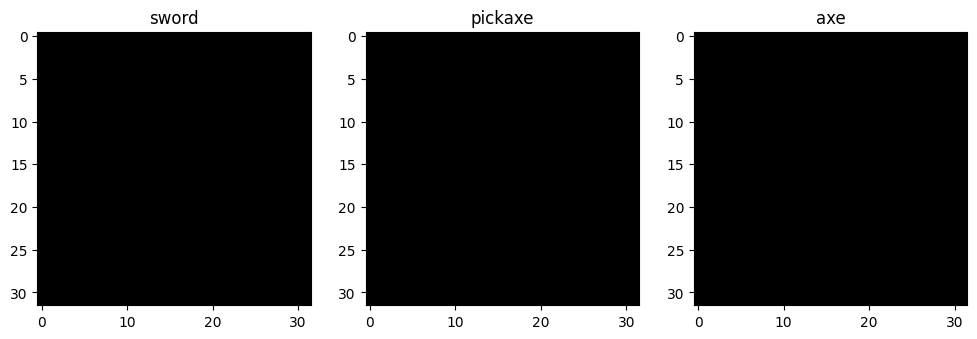

D_fake_loss_rnd=-43.656:  50%|████▉     | 500/1001 [06:48<07:42,  1.08it/s] 

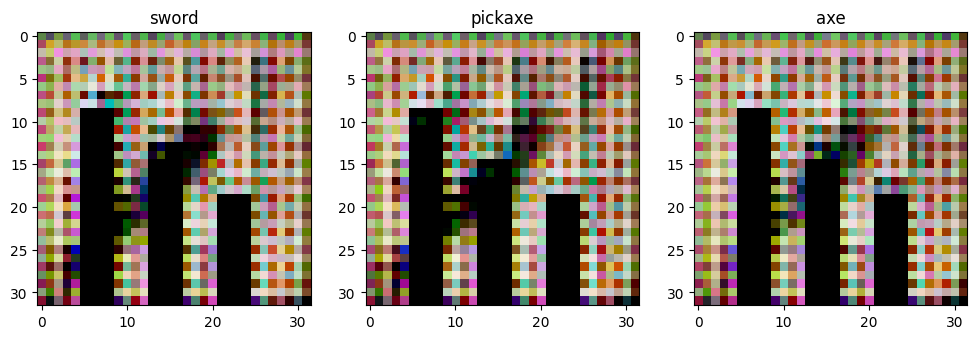

D_fake_loss_rnd=-3.555:  60%|█████▉    | 600/1001 [08:15<05:38,  1.19it/s] 

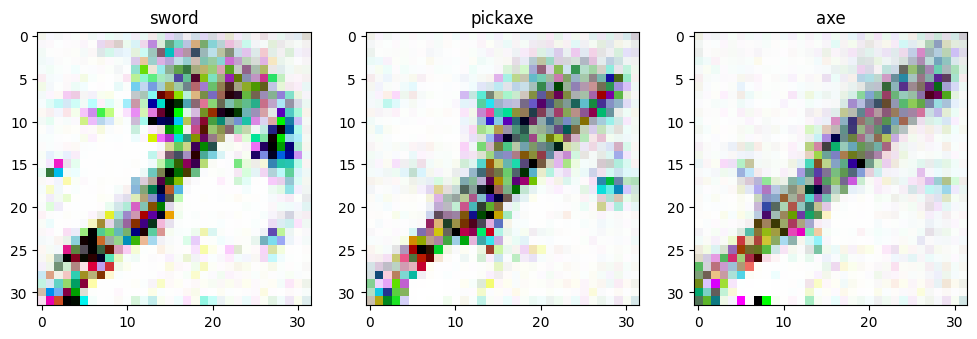

D_fake_loss_rnd=1.147:  70%|██████▉   | 700/1001 [09:39<04:09,  1.21it/s] 

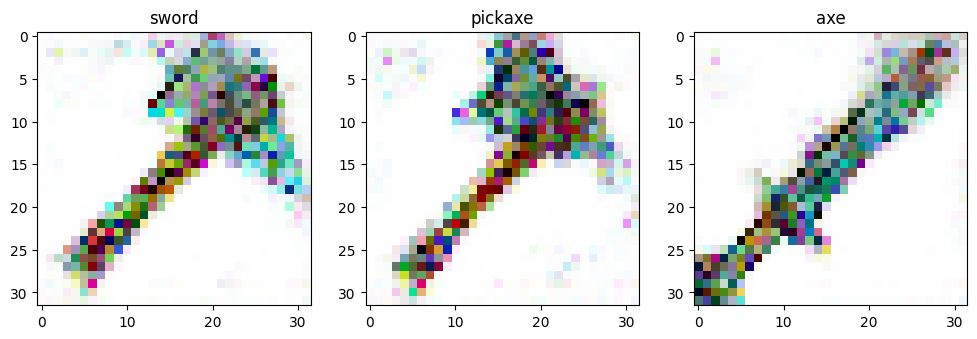

D_fake_loss_rnd=1.339:  80%|███████▉  | 800/1001 [11:01<02:41,  1.24it/s] 

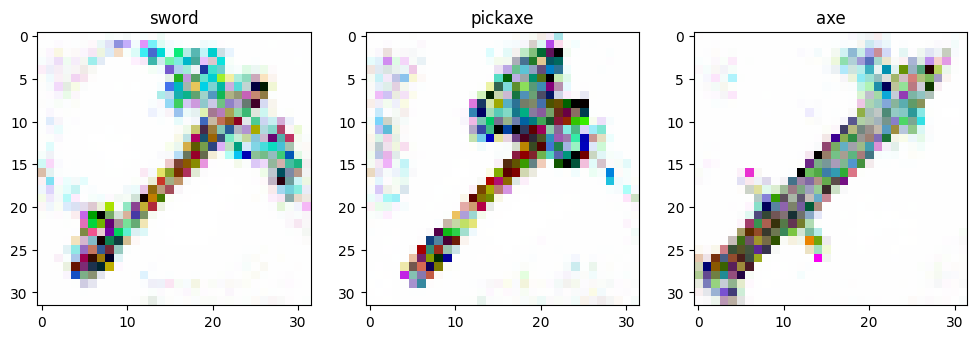

D_fake_loss_rnd=-1.861:  90%|████████▉ | 900/1001 [12:21<01:21,  1.24it/s]

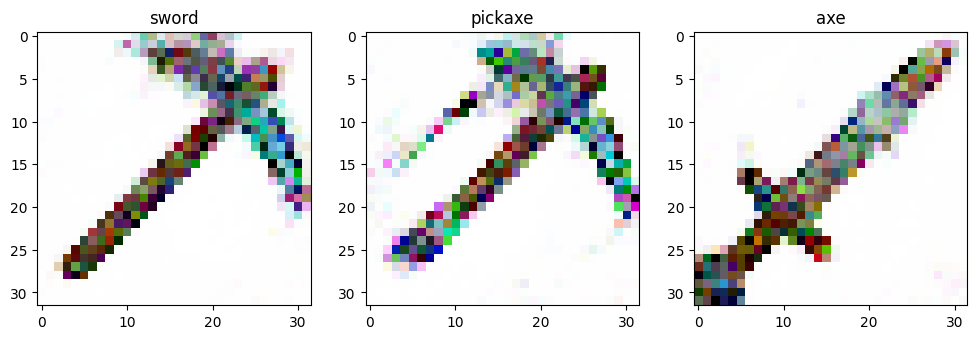

D_fake_loss_rnd=-1.545: 100%|█████████▉| 1000/1001 [13:44<00:00,  1.19it/s]

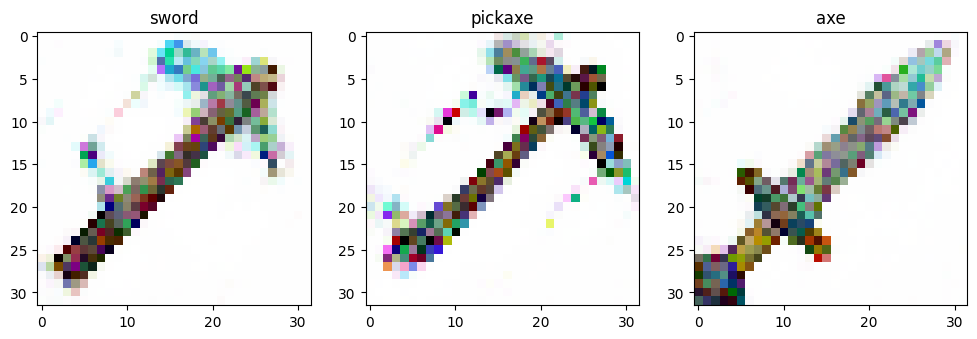

D_fake_loss_rnd=-1.545: 100%|██████████| 1001/1001 [13:44<00:00,  1.21it/s]


In [83]:
G_model     =  basic_generator(pixels, in_sz=100+num_classes*certainty_repeater, n_channels=channels, n_extra_layers=1)# Generator_Net()

# G_model     = Generator_DL_Net()

D_model     =    basic_critic(
                    pixels, 
                    n_channels=channels, 
                    n_extra_layers=1, 
                    act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
)#

D_model     = Critic(channels_img=channels, features_d=pixels)

# D_model = CriticNet()

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn = wasserstein_loss
# use a loss function that supports values between -1 and 1
# D_loss_fn = nn.BCEWithLogitsLoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )

# move everything to device
G_model.to(device)
D_model.to(device)
# D_loss_fn.to(device)

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )


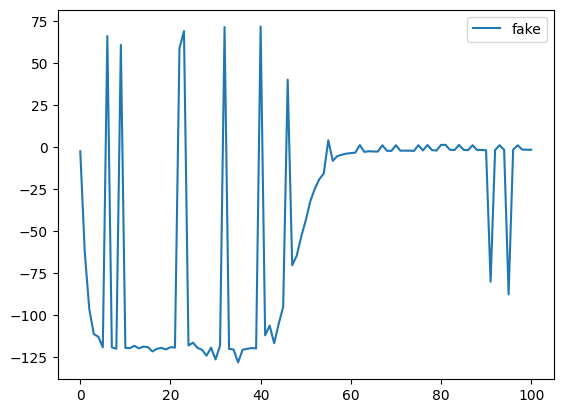

In [84]:
plot_GAN_losses(list_losses_fake)

In [85]:
label = 0
        
label_tensor = torch.zeros((num_classes)).to(device)
label_tensor[label] = 1.0

label_tensor = label_tensor.unsqueeze(0)
label_tensor = label_tensor.repeat(1, certainty_repeater)
print(label_tensor.shape)

# label_tensor = label_tensor.repeat(4, 32, 1).permute(0, 1, 2)
# label_tensor.shape

torch.Size([1, 18])


In [86]:
from sentence_transformers import SentenceTransformer, util

# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#Compute embedding for both lists
embedding = model.encode('stone sword', convert_to_tensor=True)
embedding = (embedding + 1) / 2
# compressor = nn.Linear(384, 18).to('mps')
# label_tensor = (compressor(embedding)).unsqueeze(0).to(device)
label_tensor = embedding.unsqueeze(0)#.reshape(1, channels, pixels, -1)
print(label_tensor.shape)
print(label_tensor)

torch.Size([1, 18])
tensor([[0.5053, 0.5027, 0.5027, 0.5057, 0.5062, 0.5046, 0.9781, 0.5039, 0.5115,
         0.5028, 0.5061, 0.5145, 0.5019, 0.5042, 0.9519, 0.5062, 0.5122, 0.5058]],
       device='mps:0')


/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_23627/2723397247.py:20: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img * 255).astype(np.uint8)[0])


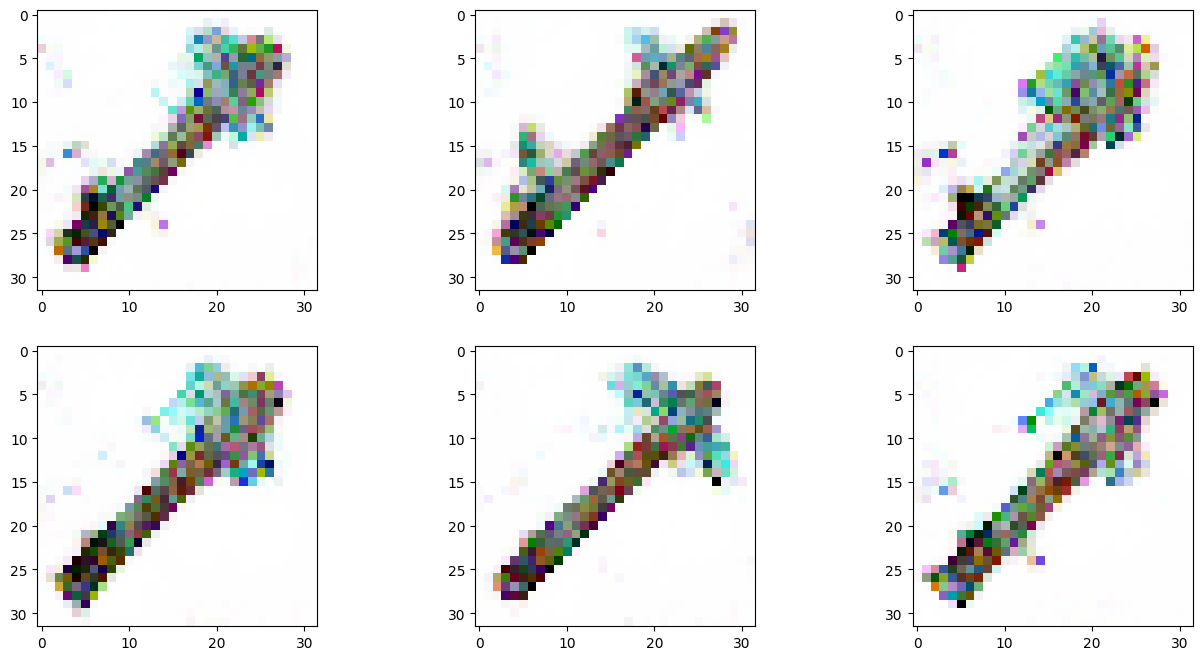

In [97]:
f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        rand = random_G_vector_input().unsqueeze(0)
        # print(rand.shape)

        inputs = torch.cat( (rand, label_tensor) , dim=1)
        output = G_model.forward( inputs).cpu()
        # convert output (batch, img_size) to (batch, 4, 32, 32)
        if channels == 4 or channels == 3:
            output = output.reshape((-1, channels, pixels, pixels))
            img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(pixels,pixels)
        elif channels == 1:
            output = output.reshape((-1, pixels, pixels))
            img = output.detach().numpy()

        # print(img.shape)
        # convert img to pil
        img = Image.fromarray((img * 255).astype(np.uint8)[0])
        # display the image
        # plt.imshow(img)
        axarr[i,j].imshow(img)#, interpolation='none', cmap='Blues'